In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics
import math

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#Set GPU to use
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.4.1


In [2]:
#code for GPU mem growth

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [3]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [4]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', 
                                             patience = 15, 
                                             restore_best_weights = True)

In [6]:
#build data generators for training and validaton

split = 0.2

total_train = 320
total_val = 78


# Define dirs and files
train_data_dir = '../data/SunnyD'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 45,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize,
                                                    subset='training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'binary',
                                                        target_size = imsize,
                                                        subset='validation')

Found 320 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


In [7]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [8]:
#load or build model
##########

#from scratch:
#base model, no top layer, w/ imagenet weights
#base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
#                                             include_top = False, 
#                                             weights = 'imagenet')

#base_model.trainable = True
#base_model.summary()

In [9]:
# add a new classifcation head

#final_layer = base_model.get_layer('out_relu')
#print('shape of last layer is ', final_layer.output_shape)
#final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
#x = layers.Flatten()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
#x = layers.Dense(1024, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# Add a dropout rate of 0.5
#x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
#x = layers.Dense(1, activation='sigmoid')(x)           

#model = Model(base_model.input, x) 
#############
#model.summary()

In [10]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=imshape),
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0

In [11]:
#build the model
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 1e-4, decay = 1e-5),
              metrics = acc_metric)

In [12]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 50,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/50
20/20 [==============================] - 6s 196ms/step - loss: 1.0429 - acc: 0.5280 - val_loss: 0.6935 - val_acc: 0.5156
Epoch 2/50
20/20 [==============================] - 4s 176ms/step - loss: 0.8553 - acc: 0.5913 - val_loss: 0.6943 - val_acc: 0.4688
Epoch 3/50
20/20 [==============================] - 3s 172ms/step - loss: 0.6229 - acc: 0.6546 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 4/50
20/20 [==============================] - 3s 174ms/step - loss: 0.6132 - acc: 0.6591 - val_loss: 0.6947 - val_acc: 0.5156
Epoch 5/50
20/20 [==============================] - 3s 172ms/step - loss: 0.5502 - acc: 0.7730 - val_loss: 0.6923 - val_acc: 0.5312
Epoch 6/50
20/20 [==============================] - 3s 174ms/step - loss: 0.5941 - acc: 0.7131 - val_loss: 0.7014 - val_acc: 0.4844
Epoch 7/50
20/20 [==============================] - 3s 174ms/step - loss: 0.5619 - acc: 0.7074 - val_loss: 0.6964 - val_acc: 0.5000
Epoch 8/50
20/20 [==============================] - 3s 171ms/step - loss: 0.

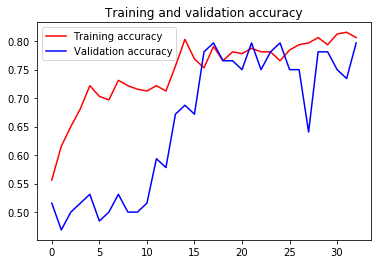

<Figure size 432x288 with 0 Axes>

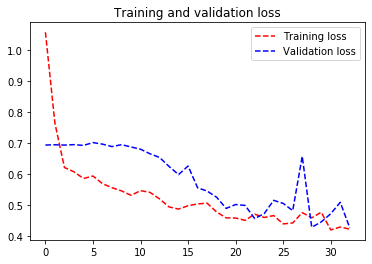

<Figure size 432x288 with 0 Axes>

In [13]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [14]:
#save the model
#filepath = './models/VGG16_model_4_8020split_TB'
#model.save(filepath)

#load model
#model = tf.keras.models.load_model(filepath, compile = True)

In [15]:
#define last conv layers
last_conv_layer_name = "max_pooling2d_2"
classifier_layer_names = [
    "flatten",
    "dense",
    "dropout",
    "dense_1",
    "dropout_1",
    "dense_2",
]


#from https://keras.io/examples/vision/grad_cam/

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = imsize)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    #grads = tape.gradient(bottom_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

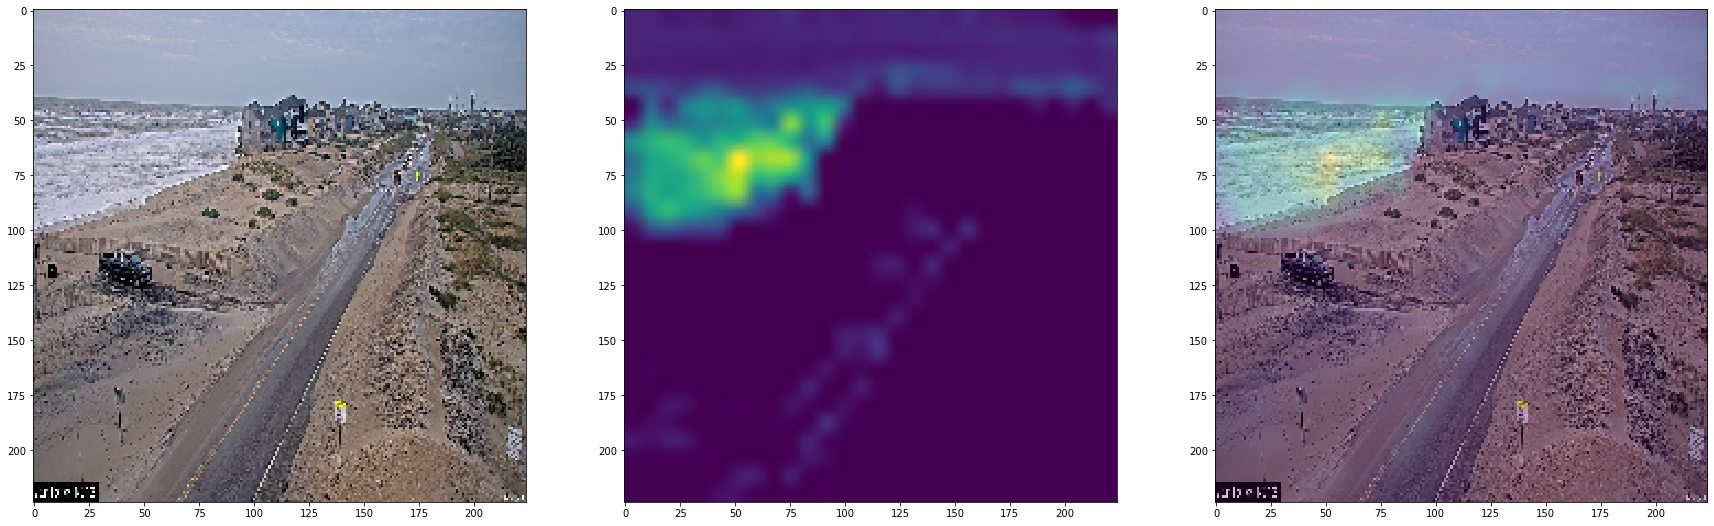

In [23]:
#from https://keras.io/examples/vision/grad_cam/
# Prepare image
impath = "../data/SunnyD/flood/2020-09-20_07_15_23.292572-Mirlo.jpg"
#impath = "../data/SunnyD/flood/2020-09-20_07_35_33.722493-Ocracoke.jpg"
#impath = "../data/SunnyD/flood/2020-09-20_09_25_50.967305-Canal.jpg"



img = tf.keras.preprocessing.image.load_img(impath,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img_array = np.expand_dims(img,axis=0)


# Make the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)
    
# get the original ERI image
Orimg = tf.keras.preprocessing.image.load_img(impath, target_size = imsize)
Orimg = tf.keras.preprocessing.image.img_to_array(Orimg)

# rescale image (range 0-255)
heatmap = np.uint8(255 * heatmap)

# use viridis for heatmap
vir = cm.get_cmap("viridis")
vir_colors = vir(np.arange(256))[:, :3]
vir_heatmap = vir_colors[heatmap]

# make the heatmap
vir_heatmap = tf.keras.preprocessing.image.array_to_img(vir_heatmap)
vir_heatmapI = vir_heatmap.resize((Orimg.shape[1], Orimg.shape[0]))
vir_heatmap = tf.keras.preprocessing.image.img_to_array(vir_heatmapI)

#put heatmpa on image
superimposed_img = vir_heatmap * 0.4 + Orimg
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Display Image, heatmap and overlay
# Display heatmap
plt.figure(figsize=(30,30))
plt.subplot(131)
plt.imshow(tf.keras.preprocessing.image.load_img(impath, target_size = imsize))
plt.subplot(132)
plt.imshow(vir_heatmapI)
plt.subplot(133)
plt.imshow(superimposed_img)
    
#save it
#plt.savefig('GradCam.pdf'.format(ip), format='pdf')